In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy as pt
from theano import shared
%matplotlib inline
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy import optimize
import regex as re


In [2]:
df = pd.read_csv('../other/frac_merge_peak.csv')


In [3]:
df['Field_Code'] = pd.Categorical(df['XEC_FIELD']).codes
df['Reservoir_Code'] = pd.Categorical(df['Reservoir']).codes


In [4]:
df.groupby(['Reservoir', 'Reservoir_Code'])['Reservoir'].count()


Reservoir         Reservoir_Code
Wolfcamp Shale A  0                 89
Wolfcamp Shale C  1                 14
Wolfcamp Shale D  2                 75
Name: Reservoir, dtype: int64

In [5]:
df.columns


Index([u'PropID', u'RSID', u'End_Date', u'Reservoir', u'Completed_Feet',
       u'#_of_Stages', u'Stage_Length', u'Clusters/Stage', u'Cluster_Spacing',
       u'Perfs/Cluster', u'Fluid_Bbls', u'Fluid_Gal/Ft', u'Fluid_Gal/Cluster',
       u'Fluid_Gal/Perf', u'Prop_Lbs', u'Prop_Lbs/Ft', u'Prop_Lbs/Cluster',
       u'Prop_Lbs/Perf', u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Avg_Rate',
       u'Max_Rate', u'Rate/Ft', u'Rate/Cluster', u'Rate/Perf', u'Avg_Pressure',
       u'Max_Pressure', u'ISIP/Ft', u'5"_SIP/Ft', u'PROPNUM', u'XEC_FIELD',
       u'OPERATOR', u'COUNTY', u'STATE', u'M_LATITUDE', u'M_LONGITUDE',
       u'MAJOR', u'SPUD_DATE', u'FIRST_PROD', u'Wet_Gas_EUR', u'Dry_Gas_EUR',
       u'Oil_EUR', u'NGL_EUR', u'Days_Production', u'OIL_Peak',
       u'OIL_Days_to_Peak', u'Field_Code', u'Reservoir_Code'],
      dtype='object')

In [6]:
X = df[[u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc', 
        u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Cluster_Spacing', u'Avg_Pressure', u'Prop_Lbs/Ft', 
        u'Prop_Lbs/Perf', u'Max_Pressure', u'Fluid_Gal/Perf', u'Fluid_Gal/Ft', u'Prop_Lbs/Cluster', 
        u'Fluid_Gal/Cluster', u'Field_Code', u'Reservoir_Code']]
y = df[[u'OIL_Peak']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape


(133, 21)

//anaconda/lib/python2.7/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


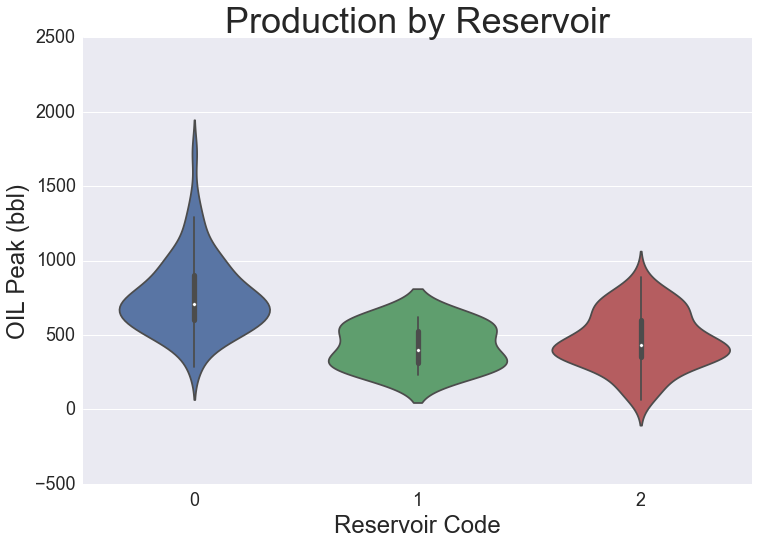

In [7]:
y_plot = pd.concat((y_train, X_train['Reservoir_Code']), axis=1)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.violinplot(y_plot['OIL_Peak'], groupby=y_plot['Reservoir_Code'])
ax.set_title('Production by Reservoir', fontsize=36)
ax.set_xlabel('Reservoir Code', fontsize=24)
ax.set_ylabel('OIL Peak (bbl)', fontsize=24)
font_size = 18
font_name = 'sans'
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
# plt.savefig('../other/figures/reservoir_violinplot', dpi=400)

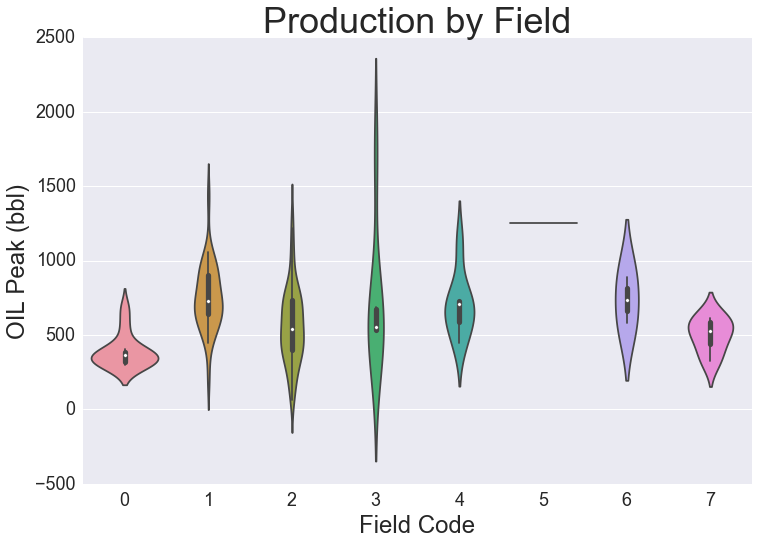

In [8]:
y_plot = pd.concat((y_train, X_train['Field_Code']), axis=1)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
sns.violinplot(y_plot['OIL_Peak'], groupby=y_plot['Field_Code'])
ax.set_title('Production by Field', fontsize=36)
ax.set_xlabel('Field Code', fontsize=24)
ax.set_ylabel('OIL Peak (bbl)', fontsize=24)
font_size = 18
font_name = 'sans'
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(font_size)
    tick.label.set_fontname(font_name)
# plt.savefig('../other/figures/field_violinplot', dpi=400)

In [9]:
def standardize_2sd(df):
    return (df - df.mean(0)) / (2 * df.std(0))

def standardize_2sd_test(df_test, df_train):
    return (df_test - df_train.mean(0)) / (2 * df_train.std(0))


In [10]:
ft_endog = u'OIL_Peak'
fts_cat = u'Reservoir_Code'
fts_num = [u'Clusters/Stage', u'Perfs/Cluster', u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal/Perf']
dfs = pd.concat((y_train, X_train[fts_cat], standardize_2sd(X_train[fts_num])),1)
dfs.columns

Index([u'OIL_Peak', u'Reservoir_Code', u'Clusters/Stage', u'Perfs/Cluster',
       u'#_of_Stages', u'ISIP/Ft', u'Rate/Ft', u'Rate/Perf', u'Avg_Prop_Conc',
       u'Max_Prop_Conc', u'Rate/Cluster', u'Max_Rate', u'Avg_Pressure',
       u'Max_Pressure', u'Fluid_Gal/Perf'],
      dtype='object')

In [11]:
dfs.columns = [u'OIL_Peak', u'Reservoir_Code', u'Clusters_Stage', u'Perfs_Cluster', u'Num_of_Stages',
       u'ISIP_Ft', u'Rate_Ft', u'Rate_Perf', u'Avg_Prop_Conc',
       u'Max_Prop_Conc', u'Rate_Cluster', u'Max_Rate', u'Avg_Pressure',
       u'Max_Pressure', u'Fluid_Gal_Perf']
fts_num = [u'Clusters_Stage', u'Perfs_Cluster', u'Num_of_Stages', u'ISIP_Ft', u'Rate_Ft', u'Rate_Perf', 
                 u'Avg_Prop_Conc', u'Max_Prop_Conc', u'Rate_Cluster', u'Max_Rate', u'Avg_Pressure', u'Max_Pressure', 
                 u'Fluid_Gal_Perf']

In [12]:
fml_equation = '{} ~ '.format(ft_endog) + ' + '.join(fts_num)
print(fml_equation)

OIL_Peak ~ Clusters_Stage + Perfs_Cluster + Num_of_Stages + ISIP_Ft + Rate_Ft + Rate_Perf + Avg_Prop_Conc + Max_Prop_Conc + Rate_Cluster + Max_Rate + Avg_Pressure + Max_Pressure + Fluid_Gal_Perf


In [13]:
(y_dmat, X_dmat) = pt.dmatrices(fml_equation, dfs , return_type='dataframe', NA_action='raise')
X_dmat.head()

,Intercept,Clusters_Stage,Perfs_Cluster,Num_of_Stages,ISIP_Ft,Rate_Ft,Rate_Perf,Avg_Prop_Conc,Max_Prop_Conc,Rate_Cluster,Max_Rate,Avg_Pressure,Max_Pressure,Fluid_Gal_Perf
2,1.0,-0.093921,1.029228,-0.647502,0.070073,-0.724103,-0.962975,-0.774617,-0.032683,0.202250,0.353341,-0.624155,0.301898,-1.163110
100,1.0,-0.093921,-0.300421,-0.127153,-0.233839,0.287866,0.516244,-0.191008,-0.305783,0.009429,0.221334,0.143933,-0.388353,0.555574
122,1.0,0.473872,-0.256099,0.002934,-0.537750,-0.133788,0.120024,-0.019359,0.064040,-0.242196,0.287337,-0.466678,-0.536005,0.141536
154,1.0,0.473872,-0.189617,0.436559,-0.765683,0.625189,0.014366,0.529919,-0.174923,-0.171085,0.492683,-0.319161,0.440821,-0.306347
51,1.0,-0.093921,-0.300421,-0.213878,0.298006,-0.133788,0.031976,0.941878,0.109557,-0.443223,-1.201417,-0.064584,-0.529459,-0.207390


In [43]:
run_res_unpooled = True

In [36]:
with pm.Model() as mdl_res_unpooled:
   
    # define priors, use Normal
    b0 = pm.Normal('b0', mu=0, sd=100, shape=dfs['Reservoir_Code'].nunique())
    b1 = pm.Normal('b1_Clusters/Stage', mu=0, sd=100)
    b2 = pm.Normal('b2_Perfs/Cluster', mu=0, sd=100)
    b3 = pm.Normal('b3_#_of_Stages', mu=0, sd=100)
    b4 = pm.Normal('b4_ISIP/Ft', mu=0, sd=100)
    b5 = pm.Normal('b5_Rate/Ft', mu=0, sd=100)
    b6 = pm.Normal('b6_Rate/Perf', mu=0, sd=100)
    b7 = pm.Normal('b7_Avg_Prop_Conc', mu=0, sd=100)
    b8 = pm.Normal('b8_Max_Prop_Conc', mu=0, sd=100)
    b9 = pm.Normal('b9_Rate/Cluster', mu=0, sd=100)
    b10 = pm.Normal('b10_Max_Rate', mu=0, sd=100)
    b11 = pm.Normal('b11_Avg_Pressure', mu=0, sd=100)
    b12 = pm.Normal('b12_Max_Pressure', mu=0, sd=100)    
    b13 = pm.Normal('b13_Fluid_Gal/Perf', mu=0, sd=100)    
    
    # define linear model
    y =    ( b0[dfs['Reservoir_Code']] +
             b1 * X_dmat['Clusters_Stage'] + 
             b2 * X_dmat['Perfs_Cluster'] +
             b3 * X_dmat['Num_of_Stages'] +
             b4 * X_dmat['ISIP_Ft'] +
             b5 * X_dmat['Rate_Ft'] +
             b6 * X_dmat['Rate_Perf'] +
             b7 * X_dmat['Avg_Prop_Conc'] +
             b8 * X_dmat['Max_Prop_Conc'] +
             b9 * X_dmat['Rate_Cluster'] +
             b10 * X_dmat['Max_Rate'] +
             b11 * X_dmat['Avg_Pressure'] +
             b12 * X_dmat['Max_Pressure'] +
             b13 * X_dmat['Fluid_Gal_Perf'])

    ## Likelihood (sampling distribution) of observations
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    likelihood = pm.Normal('likelihood', mu=y, sd=epsilon, observed=dfs[ft_endog])
 
    if run_res_unpooled:
        trc_res_unpooled = pm.backends.text.load('../other/traces_txt/trc_res_unpooled')
    else:
        step = pm.NUTS()
        start = pm.find_MAP()
        trace = pm.backends.Text('../other/traces_txt/trc_res_unpooled')
        trc_res_unpooled = pm.sample(2000, step, start, trace)
        

Applied log-transform to epsilon and added transformed epsilon_log_ to model.
100%|██████████| 2000/2000 [00:13<00:00, 152.93it/s]


In [16]:
def plot_traces(trcs, varnames=None):
    ''' Convenience fn: plot traces with overlaid means and values '''

    nrows = len(trcs.varnames)
    if varnames is not None:
        nrows = len(varnames)
    
    ax = pm.traceplot(trcs, varnames=varnames, figsize=(12,nrows*1.4)
        ,lines={k: v['mean'] for k, v in 
            pm.df_summary(trcs,varnames=varnames).iterrows()}
        ,combined=True)

    # don't label the nested traces (a bit clumsy this: consider tidying)
    dfmns = pm.df_summary(trcs, varnames=varnames)['mean'].reset_index()
    dfmns.rename(columns={'index':'featval'}, inplace=True)
    dfmns = dfmns.loc[dfmns['featval'].apply(lambda x: re.search('__[1-9]{1,}', x) is None)]
    dfmns['draw'] = dfmns['featval'].apply(lambda x: re.search('__0{1}$', x) is None)
    dfmns['pos'] = np.arange(dfmns.shape[0])
    dfmns.set_index('pos', inplace=True)
    
    for i, r in dfmns.iterrows():
        if r['draw']:
            ax[i,0].annotate('{:.2f}'.format(r['mean']), xy=(r['mean'],0)
                    ,xycoords='data', xytext=(5,10)
                    ,textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')    
        
def create_smry(trc, dfs, pname='mfr'):
    ''' Conv fn: create trace summary for sorted forestplot '''

    dfsm = pm.df_summary(trc).reset_index()
    dfsm.rename(columns={'index':'featval'}, inplace=True)
    dfsm = dfsm.loc[dfsm['featval'].apply(
        lambda x: re.search('{}__[0-9]+'.format(pname), x) is not None)]

    dfsm.set_index(dfs[pname].unique(), inplace=True)
    dfsm.sort('mean', ascending=True, inplace=True)
    dfsm['ypos'] = np.arange(len(dfsm))
    
    return dfsm
        
def custom_forestplot(df, ylabel='reservoir', size=8, aspect=0.8, facetby=None):
    ''' Conv fn: plot features from pm.df_summary using seaborn
        Facet on sets of forests for comparison '''
        
    g = sns.FacetGrid(col=facetby, hue='mean', data=df, palette='RdBu_r'
                      ,size=size, aspect=aspect)
    _ = g.map(plt.scatter, 'mean', 'ypos'
                ,marker='o', s=100, edgecolor='#333333', linewidth=0.8, zorder=10)
    _ = g.map(plt.hlines, 'ypos', 'hpd_2.5','hpd_97.5', color='#aaaaaa')

    _ = g.axes.flat[0].set_ylabel(ylabel)
    _ = [ax.set_xlabel('coeff value') for ax in g.axes.flat]
    _ = g.axes.flat[0].set_ylim((-1, df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticks(np.arange(df['ypos'].max()+1))
    _ = g.axes.flat[0].set_yticklabels(df.index)
    

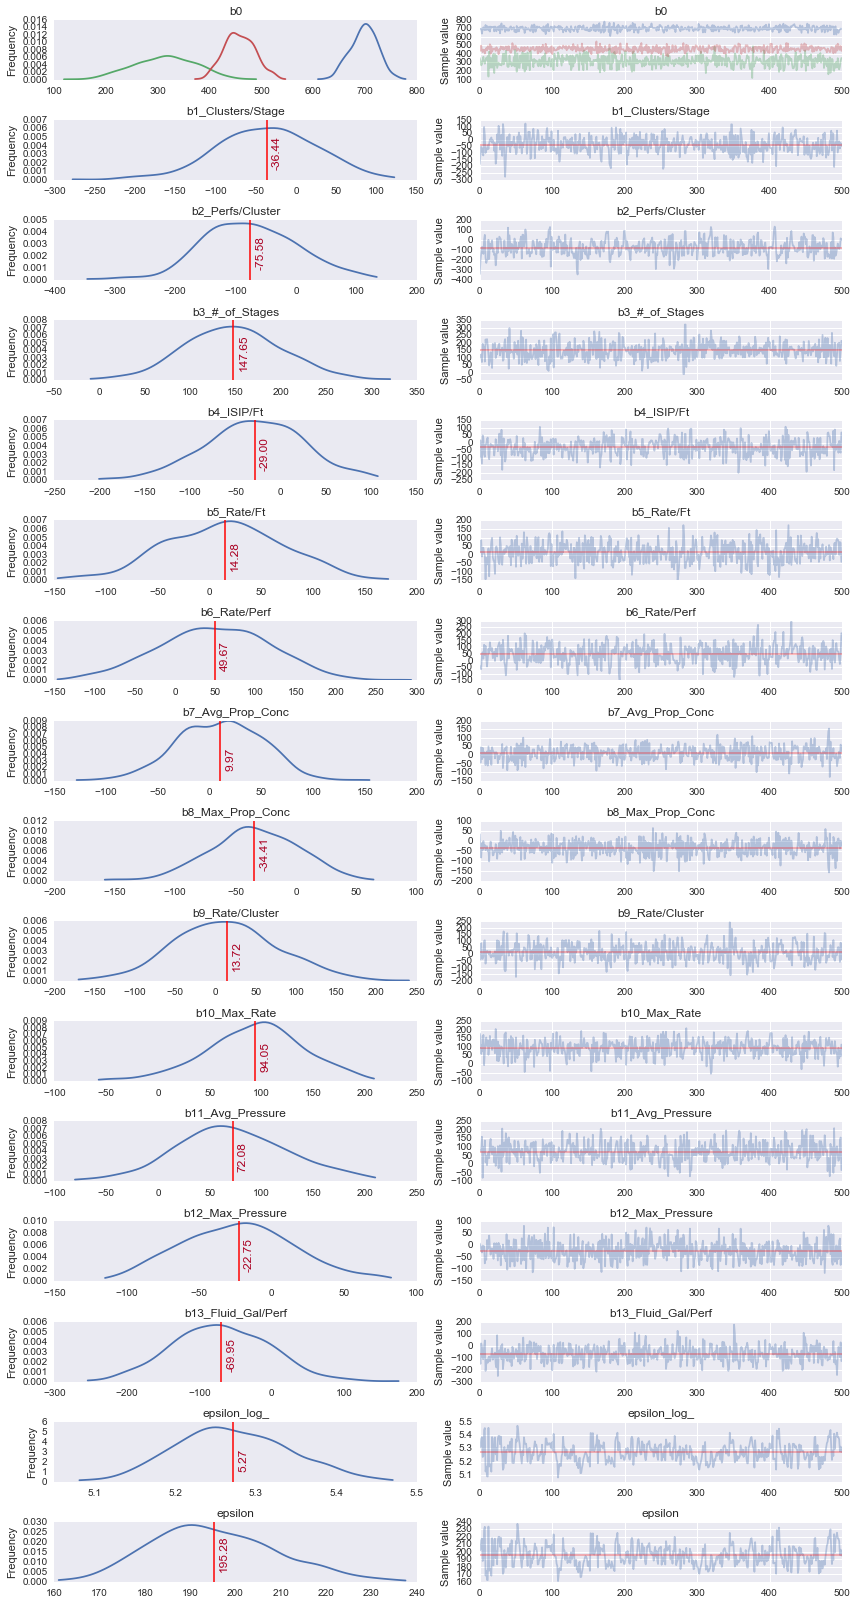

In [37]:
rvs_res_unpooled = [rv.name for rv in mdl_res_unpooled.unobserved_RVs]
plot_traces(trc_res_unpooled[-500:], varnames=rvs_res_unpooled)


In [38]:
pm.df_summary(trc_res_unpooled[-500:])


,mean,sd,mc_error,hpd_2.5,hpd_97.5
b0__0,698.249114,26.456896,1.083194,646.458844,744.377387
b0__1,313.568906,60.603540,2.184159,199.841329,426.562455
b0__2,457.807562,29.409692,1.137697,404.369271,519.204991
b1_Clusters/Stage,-36.435957,62.618522,2.776619,-145.767249,93.355153
b2_Perfs/Cluster,-75.577147,79.468917,4.295520,-208.098438,90.530575
b3_#_of_Stages,147.647383,54.328265,2.145404,49.690324,264.842272
b4_ISIP/Ft,-28.997899,54.823583,2.506604,-121.724577,96.887935
b5_Rate/Ft,14.281793,56.807410,2.570272,-86.362346,126.845028
b6_Rate/Perf,49.671118,70.066753,3.425890,-102.916203,167.874289
b7_Avg_Prop_Conc,9.970811,41.120107,1.929355,-71.018112,80.503537


In [39]:
dfsm_res_unpooled = create_smry(trc_res_unpooled[-500:], dfs, 'Reservoir_Code')
custom_forestplot(dfsm_res_unpooled)


ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [40]:
dfs.groupby(['Reservoir_Code'])['Reservoir_Code'].count()


Reservoir_Code
0    69
1     9
2    55
Name: Reservoir_Code, dtype: int64

In [44]:
ppc_res_unpooled = pm.sample_ppc(trc_res_unpooled[-500:], samples=500, model=mdl_res_unpooled, size=50)
y_pred_res_unpooled = ppc_res_unpooled['likelihood'].mean(axis=1).mean(axis=0)
waic_res_unpooled = pm.stats.waic(model=mdl_res_unpooled, trace=trc_res_unpooled[-500:])
print 'Train_RMSE: {0}'.format(np.sqrt(mean_squared_error(y_train, y_pred_res_unpooled)))
print 'Train_R2: {0}'.format(r2_score(y_train, y_pred_res_unpooled))
print 'Train_WAIC: {0}'.format(waic_res_unpooled)


Train_RMSE: 186.610409482
Train_R2: 0.516697834399
Train_WAIC: 1796.2680508


//anaconda/lib/python2.7/site-packages/pymc3/stats.py:138: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
